# ADA Project Milestone P3

## <span style="color: green;">Import libraries and set paths </span>

In [1]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import unidecode as ud
from tqdm import tqdm
from collections import Counter
from datetime import datetime
%matplotlib inline

from preprocessing_functions import *


### Set the global variables for the paths to the data folder

In [2]:
# add your data folder into the 'code' folder, make sure it is in the .gitignore file

CODE_DIR = os.getcwd()
DATA_DIR = os.path.join(CODE_DIR, 'data')

print('your data directory:', DATA_DIR)

# set path for BeerAdvocate data
DATA_BeerAdvocate = os.path.join(DATA_DIR, "BeerAdvocate.tar")

# set path for RateBeer data
DATA_RateBeer = os.path.join(DATA_DIR, "RateBeer.tar")

# set path for MatchedBeer data
DATA_MatchedBeers = os.path.join(DATA_DIR, "matched_beer_data.tar")

your data directory: c:\Users\asus\Documents\GitHub\ada-2023-project-adarescueteam\code\data


## <span style="color: green;">Preproccesing</span>

## <span style="color: green;">Load cleaned data </span>

## RaterBeer (RB) Data

#### beers, breweries, users csv's

In [3]:
# read in the BeerAdvocate files
BA_beers = pd.read_csv(os.path.join(DATA_BeerAdvocate, "beers.csv"))
BA_breweries = pd.read_csv(os.path.join(DATA_BeerAdvocate, "breweries.csv"))
BA_users = pd.read_csv(os.path.join(DATA_BeerAdvocate, "users.csv"), 
                       converters={"joined": convert_timestamp})

#### ratings pickle

In [14]:
# read RB_ratings from pickle file
with open(os.path.join(DATA_RateBeer, "RB_ratings.pkl"), 'rb') as f:
    RB_ratings = pickle.load(f)


## BeerAdvocate (BA) Data

#### beers, breweries, users csv's

In [4]:
# read in the RateBeer files
RB_beers = pd.read_csv(os.path.join(DATA_RateBeer, "beers.csv"))
RB_breweries = pd.read_csv(os.path.join(DATA_RateBeer, "breweries.csv"))
RB_users = pd.read_csv(os.path.join(DATA_RateBeer, "users.csv"),
                       converters={"joined": convert_timestamp})

#### ratings pickle

In [18]:
# read BA_ratings from pickle file
with open(os.path.join(DATA_BeerAdvocate, "BA_ratings.pkl"), 'rb') as f:
    BA_ratings = pickle.load(f)

## Glutenfree (gf) Beer Data

In [3]:
# read in the glutenfree beers
rb_gf_ratings=pd.read_csv(os.path.join(DATA_RateBeer, 'rb_gf_ratings.csv'), low_memory=False, encoding='utf-8')
ba_gf_ratings=pd.read_csv(os.path.join(DATA_BeerAdvocate, 'ba_gf_ratings.csv'), low_memory=False, encoding='utf-8')
rb_gf_ratings.shape, ba_gf_ratings.shape

((3770, 18), (2397, 19))

In [4]:
# add the review columns to the rb_gf_ratings
rb_gf_ratings['review'] = True

In [5]:
# merge the two datasets
gf_ratings = pd.concat([rb_gf_ratings, ba_gf_ratings])
gf_ratings.shape

(6167, 19)

In [6]:
# check duplicates
gf_ratings.duplicated().sum()

0

## <span style="color: green;">Filter data for matching </span>

### Filter by style

In this section, we want to match the glutenfree (gf) beers by style with the conventional beers. For this we can remove all the style in the BA or RB dataset, which is not represented in the gf beer dataset.

Following this, we merge the two _style datasets and check for duplicates.

In [23]:
#Keep only beer-types present in gluten-free beers

gf_beers=gf_ratings['beer_name'].unique()

for i in range(len(gf_beers)): #Somehow there is a space at beginning of beer_names
    gf_beers[i]=gf_beers[i][1:]

BA_gf_beertypes = BA_beers[BA_beers['beer_name'].isin(gf_beers)]['style'].unique()
RB_gf_beertypes = RB_beers[RB_beers['beer_name'].isin(gf_beers)]['style'].unique()

In [24]:
gf_beertypes = np.concatenate((BA_gf_beertypes,RB_gf_beertypes))
gf_beertypes=pd.DataFrame(gf_beertypes,columns=['style'])
gf_beertypes=gf_beertypes['style'].unique()

In [25]:
# represent only the styles in the full dataset that are also represented in the glutenfree dataset
# Here we do the comparison by first extracting the beer_id with the beer style from the datasets, as there is issues comparing directly the array gf_beertypes

# for BeerAdvocate 
BA_beers[BA_beers['style'].isin(gf_beertypes)]  # 169793 rows
BA_beerID_style = BA_beers[BA_beers['style'].isin(gf_beertypes)][['beer_id', 'style']]
BA_ratings_style = BA_ratings[BA_ratings['beer_id'].isin(BA_beerID_style['beer_id'])]

# and the same for Ratebeer
RB_beers[RB_beers['style'].isin(gf_beertypes)]
RB_beerID_style = RB_beers[RB_beers['style'].isin(gf_beertypes)][['beer_id', 'style']]
RB_ratings_style = RB_ratings[RB_ratings['beer_id'].isin(RB_beerID_style['beer_id'])]

In [26]:
# merge this two dataframes
    # beforehands, we add a review column to avoid nan conflicts later
RB_ratings_style['review'] = True
ratings_style = pd.concat([BA_ratings_style, RB_ratings_style])
ratings_style.shape 

C:\Users\fulci\AppData\Local\Temp\ipykernel_16416\130779583.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RB_ratings_style['review'] = True


(9371934, 17)

In [27]:
# check for duplicates
ratings_style.duplicated().sum()

12

In [28]:
# remove all duplicates and check again
ratings_style = ratings_style[~ratings_style.duplicated(keep='first')]
ratings_style.duplicated().sum()

0

We want to make sure that the glutenfree beers are not contained in the full data, especially because not subtracting the gf data would produce duplicates in the analysis and thus unwanted perfect matchings between the same samples.

In [29]:
# merge the two dfs and only keep the rows that are present in ratings_style but not in gf_ratings
merged_ratings = pd.merge(ratings_style, gf_ratings, indicator=True, how='outer')
ratings_style = merged_ratings[merged_ratings['_merge'] == 'left_only'].drop(columns=['_merge', 'location', 'year'])
ratings_style

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,review
0,Régab,142544,Societe des Brasseries du Gabon (SOBRAGA),37262,Euro Pale Lager,4.5,2015-08-20 10:00:00,nmann08,nmann08.184925,3.25,2.75,3.25,2.75,3.0,2.88,"From a bottle, pours a piss yellow color with...",True
1,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,2009-02-20 11:00:00,StJamesGate,stjamesgate.163714,3.0,3.5,3.5,4.0,3.5,3.67,Pours pale copper with a thin head that quick...,True
2,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,2006-03-13 11:00:00,mdagnew,mdagnew.19527,4.0,3.5,3.5,4.0,3.5,3.73,"500ml Bottle bought from The Vintage, Antrim....",True
3,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,2004-12-01 11:00:00,helloloser12345,helloloser12345.10867,4.0,3.5,4.0,4.0,4.5,3.98,Serving: 500ml brown bottlePour: Good head wi...,True
4,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,2004-08-30 10:00:00,cypressbob,cypressbob.3708,4.0,4.0,4.0,4.0,4.0,4.00,"500ml bottlePours with a light, slightly hazy...",True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9371917,Svejk Blonde,220897,Svejk Beer Garden,17155,Pale Lager,nan,2014-09-18 10:00:00,Travlr,83882,3,6,2,5,10,2.60,"Draft at the source. Clear golden color, fluf...",True
9371918,Svejk Blonde,220897,Svejk Beer Garden,17155,Pale Lager,nan,2013-12-01 11:00:00,TBone,10233,2,5,2,6,10,2.50,"Tap @brewpub, TiraneClear golden color, good ...",True
9371919,Svejk Dark,220898,Svejk Beer Garden,17155,Dunkel/Tmavý,nan,2014-11-04 11:00:00,Rob_D_UK,257161,3,4,2,5,9,2.30,In their beer garden after a walking tour aro...,True
9371920,Svejk Dark,220898,Svejk Beer Garden,17155,Dunkel/Tmavý,nan,2014-09-16 10:00:00,Travlr,83882,3,5,1,4,6,1.90,"Draft at the source. Hazy maroon color, tan h...",True


Now let's prepare the dataset for the third question which looks at the reviews, we filter out the samples that have no review and create **reviews_style**

In [30]:
(ratings_style['review']!=True).sum()

4810208

In [31]:
reviews_style = ratings_style[(ratings_style['review'] == True)]
reviews_style.shape

(4557944, 17)

In [32]:
# save as pickle 
#with open(os.path.join(DATA_DIR, "reviews_style.pkl"), 'wb') as f:
#    pickle.dump(reviews_style, f)

##### Load the reviews by style from pickle

In [4]:
with open(os.path.join(DATA_DIR, "reviews_style.pkl"), 'rb') as f:
    reviews_style = pickle.load(f)

Finally, we only want to focus on the reviews that are either english or french, thus we remove all languages that we are not interested in.

In [34]:
# plit the dataframe the more efficient way..

parts = 7
length = (len(reviews_style) // parts) + 1
split_reviews = []
for i in range(parts):
    start_idx = i * length
    end_idx = min((i + 1) * length, len(reviews_style))
    split_reviews.append(reviews_style.iloc[start_idx:end_idx, :])
reviews_style_1, reviews_style_2, reviews_style_3, reviews_style_4, reviews_style_5, reviews_style_6, reviews_style_7 = split_reviews #call parts either with split_reviews[0] or reviews_style_xy

# put this function into 'filtering' auxiliary function

In [27]:
# save as pickle
#with open(os.path.join(DATA_DIR, "split_reviews.pkl"), 'wb') as f:
#    pickle.dump(split_reviews, f)

##### Load the split reviews from pickle

In [3]:
with open(os.path.join(DATA_DIR, "split_reviews.pkl"), 'rb') as f:
    split_reviews = pickle.load(f)

reviews_style_1, reviews_style_2, reviews_style_3, reviews_style_4, reviews_style_5, reviews_style_6, reviews_style_7 = split_reviews #call parts either with split_reviews[0] or reviews_style_xy


## <span style="color: green;">Language processing</span>

### Language identification

In [8]:
# import torch                  # if you run spacy, don run torch
# torch.cuda.is_available()
# !pip install spacy-transformers
# !python -m pip install --default-timeout=1000 spacy
!python -m spacy info


============================== Info about spaCy ==============================

spaCy version    3.7.2                         
Location         c:\Users\fulci\anaconda3\Lib\site-packages\spacy
Platform         Windows-10-10.0.22631-SP0     
Python version   3.11.5                        
Pipelines        en_core_web_sm (3.7.1), en_core_web_trf (3.7.3)



In [4]:
import cupy #GPU support        (dont use if not using the gpu)

In [20]:
import spacy
import spacy_transformers
from spacy.language import Language
from spacy_langdetect import LanguageDetector

def get_lang_detector(nlp, name):
    return LanguageDetector()

#spacy.require_gpu(), spacy.prefer_gpu()


In [21]:
nlp = spacy.load("en_core_web_sm")
#nlp = spacy.load("en_core_web_trf")    # works less good than _sm
Language.factory("language_detector", func=get_lang_detector)
nlp.add_pipe('language_detector', last=True)

In [7]:
reviews_languages = []

for row in tqdm(range(len(reviews_style_2))):
    try:
        doc = nlp(reviews_style_2['text'].iloc[row])
        reviews_languages.append(doc._.language['language'])
    except Exception as e:
        reviews_languages.append(np.nan)

100%|██████████| 651135/651135 [2:52:45<00:00, 62.82it/s]  


In [47]:
reviews_style_2['lang'] = reviews_languages
reviews_style_2[reviews_style_2['lang'].isna()].head() # strange that the data is not filtered out

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,review,lang
5470396,Holsten Premium Bier,3101,Holsten-Brauerei &#40;Carlsberg&#41;,540,Premium Lager,5.0,2004-05-21 10:00:00,miko,12525,3,7,3,7,16,3.6,NaN,True,NaN
5479207,Augustiner Weissbier,10130,Augustiner-Bräu,777,German Hefeweizen,5.4,2009-01-18 11:00:00,Grossecaisse,74904,3,5,3,4,10,2.5,NaN,True,NaN
5481806,Weihenstephaner Hefeweissbier,1156,Bayerische Staatsbrauerei Weihenstephan,282,German Hefeweizen,5.4,2009-01-20 11:00:00,Grossecaisse,74904,3,6,3,6,12,3.0,NaN,True,NaN
5487155,Ayinger Altbairisch Dunkel,2019,Brauerei Aying,176,Dunkel/Tmavý,5.0,2009-01-20 11:00:00,Grossecaisse,74904,4,8,4,8,16,4.0,NaN,True,NaN
5491779,Weltenburger Hefe-Weißbier Hell,82447,Brauerei Bischofshof,2015,German Hefeweizen,5.4,2009-01-20 11:00:00,Grossecaisse,74904,3,6,3,6,12,3.0,NaN,True,NaN


should have been filtered out... will sort out at the end

In [9]:
# save as pickle
#with open(os.path.join(DATA_DIR, "reviews_style_2.pkl"), 'wb') as f:
#    pickle.dump(reviews_style_2, f)

Put the snippets with the lang column together

In [27]:
# read all splits into a dataframes dictionary to concatenate in the next step

dataframes = {}  # Dictionary to store DataFrames

for i in range(1, 8):
    filename = f"reviews_style_lang_{i}.pkl"
    filepath = os.path.join(DATA_DIR, filename)

    # Load data from the pickle file
    with open(filepath, 'rb') as f:
        data = pickle.load(f)
        df = pd.DataFrame(data)  # Assuming the loaded data is in a suitable format for DataFrame creation
        dataframes[f"reviews_style_lang_{i}"] = df

In [29]:
reviews_style_lang = pd.concat(dataframes.values(), ignore_index=True)
reviews_style_lang

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,review,lang
0,33 Export (Gabon),410549,Sobraga,3198,Pale Lager,5.0,2016-04-26 10:00:00,Manslow,175852,2,4,2,4,8,2.0,"Puszka 0,33l dzięki Christoph . Kolor jasnozł...",True,pl
1,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,2017-02-17 11:00:00,MAGICuenca91,442761,2,3,2,4,8,1.9,Cerveza pale lager gabonesa. Más floja que la...,True,es
2,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,2016-06-24 10:00:00,Sibarh,288889,3,3,2,3,5,1.6,"Kolor- złoty, klarowny. Piana - drobna, średn...",True,pl
3,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,2016-01-01 11:00:00,fombe89,250510,4,3,1,2,5,1.5,"Botella, de Gabón regalo familiar.31/01/2015C...",True,es
4,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,2015-10-23 10:00:00,kevnic2008,122778,2,4,2,4,7,1.9,Many thanks for this beer to Erzengel. Pours ...,True,en
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4557939,Svejk Blonde,220897,Svejk Beer Garden,17155,Pale Lager,nan,2014-09-18 10:00:00,Travlr,83882,3,6,2,5,10,2.6,"Draft at the source. Clear golden color, fluf...",True,NaN
4557940,Svejk Blonde,220897,Svejk Beer Garden,17155,Pale Lager,nan,2013-12-01 11:00:00,TBone,10233,2,5,2,6,10,2.5,"Tap @brewpub, TiraneClear golden color, good ...",True,NaN
4557941,Svejk Dark,220898,Svejk Beer Garden,17155,Dunkel/Tmavý,nan,2014-11-04 11:00:00,Rob_D_UK,257161,3,4,2,5,9,2.3,In their beer garden after a walking tour aro...,True,NaN
4557942,Svejk Dark,220898,Svejk Beer Garden,17155,Dunkel/Tmavý,nan,2014-09-16 10:00:00,Travlr,83882,3,5,1,4,6,1.9,"Draft at the source. Hazy maroon color, tan h...",True,NaN


remove all Nan columns and filter all the english and french out

In [38]:
# show only the reviews which have a text (272 turn out to have nan)
reviews_style_lang.loc[~reviews_style_lang['text'].isna()]

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,review,lang
0,33 Export (Gabon),410549,Sobraga,3198,Pale Lager,5.0,2016-04-26 10:00:00,Manslow,175852,2,4,2,4,8,2.0,"Puszka 0,33l dzięki Christoph . Kolor jasnozł...",True,pl
1,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,2017-02-17 11:00:00,MAGICuenca91,442761,2,3,2,4,8,1.9,Cerveza pale lager gabonesa. Más floja que la...,True,es
2,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,2016-06-24 10:00:00,Sibarh,288889,3,3,2,3,5,1.6,"Kolor- złoty, klarowny. Piana - drobna, średn...",True,pl
3,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,2016-01-01 11:00:00,fombe89,250510,4,3,1,2,5,1.5,"Botella, de Gabón regalo familiar.31/01/2015C...",True,es
4,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,2015-10-23 10:00:00,kevnic2008,122778,2,4,2,4,7,1.9,Many thanks for this beer to Erzengel. Pours ...,True,en
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4557939,Svejk Blonde,220897,Svejk Beer Garden,17155,Pale Lager,nan,2014-09-18 10:00:00,Travlr,83882,3,6,2,5,10,2.6,"Draft at the source. Clear golden color, fluf...",True,NaN
4557940,Svejk Blonde,220897,Svejk Beer Garden,17155,Pale Lager,nan,2013-12-01 11:00:00,TBone,10233,2,5,2,6,10,2.5,"Tap @brewpub, TiraneClear golden color, good ...",True,NaN
4557941,Svejk Dark,220898,Svejk Beer Garden,17155,Dunkel/Tmavý,nan,2014-11-04 11:00:00,Rob_D_UK,257161,3,4,2,5,9,2.3,In their beer garden after a walking tour aro...,True,NaN
4557942,Svejk Dark,220898,Svejk Beer Garden,17155,Dunkel/Tmavý,nan,2014-09-16 10:00:00,Travlr,83882,3,5,1,4,6,1.9,"Draft at the source. Hazy maroon color, tan h...",True,NaN


In [37]:
# so much text that couldnt be quantified...
reviews_style_lang['lang'].isna().sum()

##### not removing for now.. plan could be to filter them out and retry to run the nlp... although i think the problem is because of floats in the text (run the nlp pipeline without 'try:' ... 'except: na...')

1302406

In [39]:
# save review_style_lang pickle
#with open(os.path.join(DATA_DIR, "reviews_style_lang.pkl"), 'wb') as f:
#    pickle.dump(reviews_style_lang, f)

In [8]:
# load the pickle with reviews sorted by style and with the language column
with open(os.path.join(DATA_DIR, "reviews_style_lang.pkl"), 'rb') as f:
    reviews_style_lang = pickle.load(f)

In [9]:
reviews_style_lang_en_fr = reviews_style_lang[reviews_style_lang['lang'].isin(['en', 'fr'])]
reviews_style_lang_en_fr

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,review,lang
4,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,2015-10-23 10:00:00,kevnic2008,122778,2,4,2,4,7,1.9,Many thanks for this beer to Erzengel. Pours ...,True,en
5,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,2015-10-12 10:00:00,Beerhunter111,227834,2,3,2,3,9,1.9,Many thanks to Erzengel for sharing! Pours cl...,True,en
6,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,2015-10-07 10:00:00,Erzengel,83106,4,5,4,5,8,2.6,Many thanks to Travlr for this can! Grainy n...,True,en
8,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,2014-05-29 10:00:00,Lowenbrau,37316,3,5,2,3,7,2.0,"330ml bottle. 29-05-2014.From Gabon, courtesy...",True,en
9,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,2013-07-18 10:00:00,seynie,75452,2,3,3,4,6,1.8,Light yellow with quickly disappearing foam t...,True,en
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3255670,Maine Beer 2013,236777,Maine Beer Company,10659,American Pale Ale,5.5,2013-12-12 11:00:00,czar,104498,3,8,3,7,14,3.5,"bottle shared by tom10101, thanks bro. pours ...",True,en
3255671,Maine Beer 2013,236777,Maine Beer Company,10659,American Pale Ale,5.5,2013-12-11 11:00:00,DCLawyer,221043,4,7,4,6,16,3.7,Bottle->tulip. Very cloudy orange with frothy...,True,en
3255672,Maine Beer 2013,236777,Maine Beer Company,10659,American Pale Ale,5.5,2013-12-08 11:00:00,jtclockwork,104199,4,7,3,7,14,3.5,Bottle. Pours amber peach with white head. No...,True,en
3255673,Maine Beer 2013,236777,Maine Beer Company,10659,American Pale Ale,5.5,2013-12-03 11:00:00,RamyG4,79534,5,9,4,8,14,4.0,Bottle. Mostly opaque golden beer with a medi...,True,en


Do it for the glutenfree beers as well

In [13]:
gf_reviews = gf_ratings[gf_ratings['review']==True]

In [22]:
gf_reviews_languages = []

for row in tqdm(range(len(gf_reviews))):
    try:
        doc = nlp(gf_reviews['text'].iloc[row])
        gf_reviews_languages.append(doc._.language['language'])
    except Exception as e:
        gf_reviews_languages.append(np.nan)

100%|██████████| 3770/3770 [01:04<00:00, 58.41it/s]


In [23]:
gf_reviews['lang'] = gf_reviews_languages
gf_reviews[gf_reviews['lang'].isna()]#.head() # strange that the data is not filtered out

C:\Users\fulci\AppData\Local\Temp\ipykernel_32604\2879938099.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gf_reviews['lang'] = gf_reviews_languages


,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,location,year,review,lang


In [24]:
gf_reviews

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,location,year,review,lang
0,Kowloon Bay Gluten Free IPA,436710,Kowloon Bay Brewery,25260,India Pale Ale (IPA),6.6,2016-07-26 10:00:00,CacheManyHose,282160,3,7,2,6,14,3.2,Drank at Home: Eat To Live cafe. Floral hop n...,Hong Kong,2016,True,en
1,Glutenberg 1er Anniversaire,182791,Glutenberg Brewing Company,13241,Specialty Grain,7.5,2013-07-14 10:00:00,BiereLuc,131174,3,7,3,8,16,3.7,Bière cuivrée. Nez houblon-caramel. En bouche...,Canada,2013,True,fr
2,Glutenberg 8,162109,Glutenberg Brewing Company,13241,Specialty Grain,5.0,2014-10-04 10:00:00,BiereLuc,131174,3,7,2,7,15,3.4,"En fouillant dans mes carnets, je suis retomb...",Canada,2014,True,fr
3,Glutenberg Belge de Saison 2013,204934,Glutenberg Brewing Company,13241,Saison,7.0,2013-02-21 11:00:00,BiereLuc,131174,3,8,3,8,18,4.0,"(Version 2013, recette différente) - Belle co...",Canada,2013,True,fr
4,Glutenberg Belge de Saison 2014,253815,Glutenberg Brewing Company,13241,Saison,7.0,2014-04-22 10:00:00,BiereLuc,131174,3,6,3,7,15,3.4,"Bière couleur paille, limpide et mousseuse. L...",Canada,2014,True,fr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3765,Grain dOrge Glutenfri Ekologisk Ale,475575,Grain dOrge (Brasseurs De Gayant),759,Golden Ale/Blond Ale,3.5,2017-07-24 10:00:00,Samuel214,381941,3,5,2,4,6,2.0,"Flaska från Coop Konsum. Kristallklar, ljus b...",Sweden,2017,True,sv
3766,Grain dOrge Glutenfri Ekologisk Ale,475575,Grain dOrge (Brasseurs De Gayant),759,Golden Ale/Blond Ale,3.5,2017-05-27 10:00:00,Pilsnertest,385469,3,3,1,3,6,1.6,"Can at home. Taste of paper, hay, boiled vege...",Sweden,2017,True,en
3767,Grain dOrge Glutenfri Ekologisk Ale,475575,Grain dOrge (Brasseurs De Gayant),759,Golden Ale/Blond Ale,3.5,2017-05-05 10:00:00,elosop,148291,4,5,3,7,10,2.9,Halmgul med tunt vitt skum. Doftar kryddor oc...,Sweden,2017,True,sv
3768,Grain dOrge Glutenfri Ekologisk Lager,477827,Grain dOrge (Brasseurs De Gayant),759,Pale Lager,3.5,2017-01-07 11:00:00,Malin_aiisa,361626,2,6,3,5,11,2.7,"Bottle. Pours clear amber, no head. Aroma mal...",Sweden,2017,True,en


In [25]:
gf_reviews_lang_en_fr = gf_reviews[gf_reviews['lang'].isin(['en', 'fr'])]
gf_reviews_lang_en_fr

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,location,year,review,lang
0,Kowloon Bay Gluten Free IPA,436710,Kowloon Bay Brewery,25260,India Pale Ale (IPA),6.6,2016-07-26 10:00:00,CacheManyHose,282160,3,7,2,6,14,3.2,Drank at Home: Eat To Live cafe. Floral hop n...,Hong Kong,2016,True,en
1,Glutenberg 1er Anniversaire,182791,Glutenberg Brewing Company,13241,Specialty Grain,7.5,2013-07-14 10:00:00,BiereLuc,131174,3,7,3,8,16,3.7,Bière cuivrée. Nez houblon-caramel. En bouche...,Canada,2013,True,fr
2,Glutenberg 8,162109,Glutenberg Brewing Company,13241,Specialty Grain,5.0,2014-10-04 10:00:00,BiereLuc,131174,3,7,2,7,15,3.4,"En fouillant dans mes carnets, je suis retomb...",Canada,2014,True,fr
3,Glutenberg Belge de Saison 2013,204934,Glutenberg Brewing Company,13241,Saison,7.0,2013-02-21 11:00:00,BiereLuc,131174,3,8,3,8,18,4.0,"(Version 2013, recette différente) - Belle co...",Canada,2013,True,fr
4,Glutenberg Belge de Saison 2014,253815,Glutenberg Brewing Company,13241,Saison,7.0,2014-04-22 10:00:00,BiereLuc,131174,3,6,3,7,15,3.4,"Bière couleur paille, limpide et mousseuse. L...",Canada,2014,True,fr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3762,Grain dOrge Sans Gluten Bio (Gluten Free / G...,328974,Brasserie Goudale (Saint-Omer),29110,Golden Ale/Blond Ale,5.5,2015-04-24 10:00:00,larsniclas,6693,2,5,3,6,12,2.8,Bottled from Ica à keredClear golden with a b...,Sweden,2015,True,en
3763,Castelain Jade Sans Gluten,381938,Castelain,739,Pale Lager,4.5,2017-07-18 10:00:00,PapaCanard,393710,3,6,3,4,10,2.6,Une bière sans gluten! Il lui manque ce qui e...,Switzerland,2017,True,fr
3766,Grain dOrge Glutenfri Ekologisk Ale,475575,Grain dOrge (Brasseurs De Gayant),759,Golden Ale/Blond Ale,3.5,2017-05-27 10:00:00,Pilsnertest,385469,3,3,1,3,6,1.6,"Can at home. Taste of paper, hay, boiled vege...",Sweden,2017,True,en
3768,Grain dOrge Glutenfri Ekologisk Lager,477827,Grain dOrge (Brasseurs De Gayant),759,Pale Lager,3.5,2017-01-07 11:00:00,Malin_aiisa,361626,2,6,3,5,11,2.7,"Bottle. Pours clear amber, no head. Aroma mal...",Sweden,2017,True,en


In [27]:
# merge the gf_reviews and reviews _lang_en_fr
# but first add a column 'glutenfree' to both datasets to distinguish them
gf_reviews_lang_en_fr['glutenfree'] = True
reviews_style_lang_en_fr['glutenfree'] = False

C:\Users\fulci\AppData\Local\Temp\ipykernel_32604\1875674314.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gf_reviews_lang_en_fr['glutenfree'] = True
C:\Users\fulci\AppData\Local\Temp\ipykernel_32604\1875674314.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_style_lang_en_fr['glutenfree'] = False


,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,review,lang,glutenfree
4,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,2015-10-23 10:00:00,kevnic2008,122778,2,4,2,4,7,1.9,Many thanks for this beer to Erzengel. Pours ...,True,en,False
5,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,2015-10-12 10:00:00,Beerhunter111,227834,2,3,2,3,9,1.9,Many thanks to Erzengel for sharing! Pours cl...,True,en,False
6,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,2015-10-07 10:00:00,Erzengel,83106,4,5,4,5,8,2.6,Many thanks to Travlr for this can! Grainy n...,True,en,False
8,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,2014-05-29 10:00:00,Lowenbrau,37316,3,5,2,3,7,2.0,"330ml bottle. 29-05-2014.From Gabon, courtesy...",True,en,False
9,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,2013-07-18 10:00:00,seynie,75452,2,3,3,4,6,1.8,Light yellow with quickly disappearing foam t...,True,en,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3255670,Maine Beer 2013,236777,Maine Beer Company,10659,American Pale Ale,5.5,2013-12-12 11:00:00,czar,104498,3,8,3,7,14,3.5,"bottle shared by tom10101, thanks bro. pours ...",True,en,False
3255671,Maine Beer 2013,236777,Maine Beer Company,10659,American Pale Ale,5.5,2013-12-11 11:00:00,DCLawyer,221043,4,7,4,6,16,3.7,Bottle->tulip. Very cloudy orange with frothy...,True,en,False
3255672,Maine Beer 2013,236777,Maine Beer Company,10659,American Pale Ale,5.5,2013-12-08 11:00:00,jtclockwork,104199,4,7,3,7,14,3.5,Bottle. Pours amber peach with white head. No...,True,en,False
3255673,Maine Beer 2013,236777,Maine Beer Company,10659,American Pale Ale,5.5,2013-12-03 11:00:00,RamyG4,79534,5,9,4,8,14,4.0,Bottle. Mostly opaque golden beer with a medi...,True,en,False


In [29]:
reviews_en_fr = pd.concat([gf_reviews_lang_en_fr, reviews_style_lang_en_fr])
reviews_en_fr

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,...,palate,taste,overall,rating,text,location,year,review,lang,glutenfree
0,Kowloon Bay Gluten Free IPA,436710,Kowloon Bay Brewery,25260,India Pale Ale (IPA),6.6,2016-07-26 10:00:00,CacheManyHose,282160,3,...,2,6,14,3.2,Drank at Home: Eat To Live cafe. Floral hop n...,Hong Kong,2016.0,True,en,True
1,Glutenberg 1er Anniversaire,182791,Glutenberg Brewing Company,13241,Specialty Grain,7.5,2013-07-14 10:00:00,BiereLuc,131174,3,...,3,8,16,3.7,Bière cuivrée. Nez houblon-caramel. En bouche...,Canada,2013.0,True,fr,True
2,Glutenberg 8,162109,Glutenberg Brewing Company,13241,Specialty Grain,5.0,2014-10-04 10:00:00,BiereLuc,131174,3,...,2,7,15,3.4,"En fouillant dans mes carnets, je suis retomb...",Canada,2014.0,True,fr,True
3,Glutenberg Belge de Saison 2013,204934,Glutenberg Brewing Company,13241,Saison,7.0,2013-02-21 11:00:00,BiereLuc,131174,3,...,3,8,18,4.0,"(Version 2013, recette différente) - Belle co...",Canada,2013.0,True,fr,True
4,Glutenberg Belge de Saison 2014,253815,Glutenberg Brewing Company,13241,Saison,7.0,2014-04-22 10:00:00,BiereLuc,131174,3,...,3,7,15,3.4,"Bière couleur paille, limpide et mousseuse. L...",Canada,2014.0,True,fr,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3255670,Maine Beer 2013,236777,Maine Beer Company,10659,American Pale Ale,5.5,2013-12-12 11:00:00,czar,104498,3,...,3,7,14,3.5,"bottle shared by tom10101, thanks bro. pours ...",NaN,NaN,True,en,False
3255671,Maine Beer 2013,236777,Maine Beer Company,10659,American Pale Ale,5.5,2013-12-11 11:00:00,DCLawyer,221043,4,...,4,6,16,3.7,Bottle->tulip. Very cloudy orange with frothy...,NaN,NaN,True,en,False
3255672,Maine Beer 2013,236777,Maine Beer Company,10659,American Pale Ale,5.5,2013-12-08 11:00:00,jtclockwork,104199,4,...,3,7,14,3.5,Bottle. Pours amber peach with white head. No...,NaN,NaN,True,en,False
3255673,Maine Beer 2013,236777,Maine Beer Company,10659,American Pale Ale,5.5,2013-12-03 11:00:00,RamyG4,79534,5,...,4,8,14,4.0,Bottle. Mostly opaque golden beer with a medi...,NaN,NaN,True,en,False


location and year missing in the reviews from non-glutenfree.. need a fix here

In [30]:
# save reviews_en_fr pickle
with open(os.path.join(DATA_DIR, "reviews_en_fr.pkl"), 'wb') as f:
    pickle.dump(reviews_en_fr, f)

Load the pickle for reviews_en_fr

In [31]:
with open(os.path.join(DATA_DIR, "reviews_en_fr.pkl"), 'rb') as f:
    reviews_en_fr = pickle.load(f)

In [34]:
reviews_en_fr['lang'].unique()

array(['en', 'fr'], dtype=object)

So far we obtained two major dataset:
- `review_style_lang` which contains the reviews for all beers annotated by languange, filtered by style.
- `review_en_fr` which contains the reviews for beers with english or french reviews, filtered by style, annotated by language and glutenfree status.

## <span style="color: green;">Temporal analysis</span>

-> can fill with a lot of P2_AfterMilestone from the 'fix_nlp_and_text-formats' branch 

In [3]:
# read in the dataset that is preprocessed with beer styles and language    
with open(os.path.join(DATA_DIR, "reviews_style_lang.pkl"), 'rb') as f:
    reviews_style_lang = pickle.load(f)


In [4]:
with open(os.path.join(DATA_DIR, "reviews_en_fr.pkl"), 'rb') as f:
    reviews_en_fr = pickle.load(f)

In [12]:
print(len(reviews_style_lang))
reviews_style_lang.head()

4557944


,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,review,lang
0,33 Export (Gabon),410549,Sobraga,3198,Pale Lager,5.0,2016-04-26 10:00:00,Manslow,175852,2,4,2,4,8,2.0,"Puszka 0,33l dzięki Christoph . Kolor jasnozł...",True,pl
1,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,2017-02-17 11:00:00,MAGICuenca91,442761,2,3,2,4,8,1.9,Cerveza pale lager gabonesa. Más floja que la...,True,es
2,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,2016-06-24 10:00:00,Sibarh,288889,3,3,2,3,5,1.6,"Kolor- złoty, klarowny. Piana - drobna, średn...",True,pl
3,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,2016-01-01 11:00:00,fombe89,250510,4,3,1,2,5,1.5,"Botella, de Gabón regalo familiar.31/01/2015C...",True,es
4,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,2015-10-23 10:00:00,kevnic2008,122778,2,4,2,4,7,1.9,Many thanks for this beer to Erzengel. Pours ...,True,en


In [19]:
print(len(reviews_en_fr))
reviews_en_fr.head()

3050347


,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,...,palate,taste,overall,rating,text,location,year,review,lang,glutenfree
0,Kowloon Bay Gluten Free IPA,436710,Kowloon Bay Brewery,25260,India Pale Ale (IPA),6.6,2016-07-26 10:00:00,CacheManyHose,282160,3,...,2,6,14,3.2,Drank at Home: Eat To Live cafe. Floral hop n...,Hong Kong,2016.0,True,en,True
1,Glutenberg 1er Anniversaire,182791,Glutenberg Brewing Company,13241,Specialty Grain,7.5,2013-07-14 10:00:00,BiereLuc,131174,3,...,3,8,16,3.7,Bière cuivrée. Nez houblon-caramel. En bouche...,Canada,2013.0,True,fr,True
2,Glutenberg 8,162109,Glutenberg Brewing Company,13241,Specialty Grain,5.0,2014-10-04 10:00:00,BiereLuc,131174,3,...,2,7,15,3.4,"En fouillant dans mes carnets, je suis retomb...",Canada,2014.0,True,fr,True
3,Glutenberg Belge de Saison 2013,204934,Glutenberg Brewing Company,13241,Saison,7.0,2013-02-21 11:00:00,BiereLuc,131174,3,...,3,8,18,4.0,"(Version 2013, recette différente) - Belle co...",Canada,2013.0,True,fr,True
4,Glutenberg Belge de Saison 2014,253815,Glutenberg Brewing Company,13241,Saison,7.0,2014-04-22 10:00:00,BiereLuc,131174,3,...,3,7,15,3.4,"Bière couleur paille, limpide et mousseuse. L...",Canada,2014.0,True,fr,True


## Complete the 'year' column

In non-glutenfree reviews, the year data is missing. We complete the column by extracting the corresponding information from the 'date' column.

In [20]:
# format 2016-04-26 10:00:00
reviews_style_lang['year'] = reviews_style_lang['date'].str.split('-').str[0].astype(int)
reviews_en_fr['year'] = reviews_en_fr['date'].str.split('-').str[0].astype(int)

We want to know if the temporal evolution of the reviews for glutenfree beers. Thus we plot the number of reviews per year for the glutenfree beers over time.

In [22]:
number_of_gf_reviews = Counter(reviews_en_fr[reviews_en_fr['glutenfree'] == True]['year'])
number_of_gf_reviews = sorted(number_of_gf_reviews.items(), key=lambda x: x[0])

Text(0.5, 1.0, 'Temporal analysis of glutenfree beers worldwide')

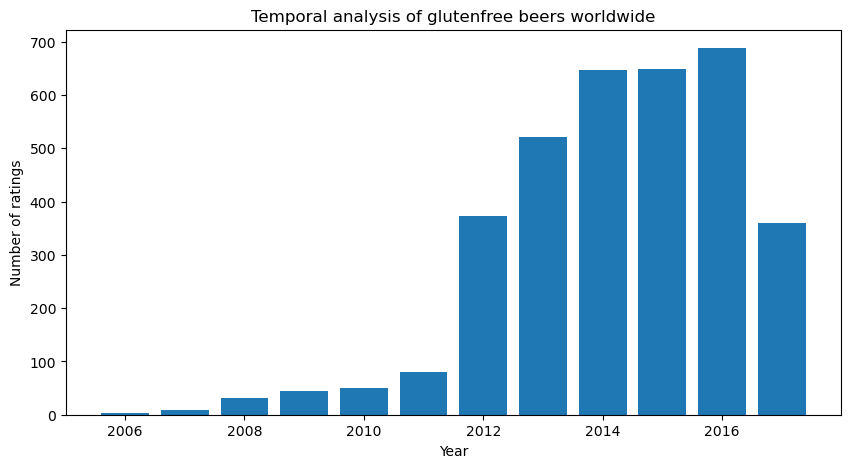

In [23]:
# make a list of ('year', 'number of ratings') tuples
plt.figure(figsize=(10,5))
plt.bar([x[0] for x in number_of_gf_reviews], [x[1] for x in number_of_gf_reviews])
plt.xlabel('Year')
plt.ylabel('Number of ratings')
plt.title('Temporal analysis of glutenfree beers worldwide')

It showed that the ammount of reviews for gluten-free beers is increasing over time. Does it reflect the increasing popularity? Or it is simply because of the increase of total number of reviews in the dataset? To answer that, the temporal evolution of all reviews was computed and applied for normalization.

In [24]:
# show unique values of the 'year' column
reviews_en_fr['year'].unique()

array([2016, 2013, 2014, 2015, 2017, 2012, 2011, 2010, 2009, 2008, 2007,
       2006, 2004, 2005, 2003, 2002, 2001, 2000])

In [25]:
# count the number of reviews per year for all year, ignore nan
number_of_all_reviews = Counter(reviews_en_fr['year'])
number_of_all_reviews = sorted(number_of_all_reviews.items(), key=lambda x: x[0])

In [32]:
number_of_gf_reviews

[(2006, 3),
 (2007, 8),
 (2008, 32),
 (2009, 45),
 (2010, 50),
 (2011, 80),
 (2012, 373),
 (2013, 521),
 (2014, 646),
 (2015, 648),
 (2016, 688),
 (2017, 360)]

Text(0.5, 1.0, 'Temporal analysis of glutenfree beers proportion worldwide')

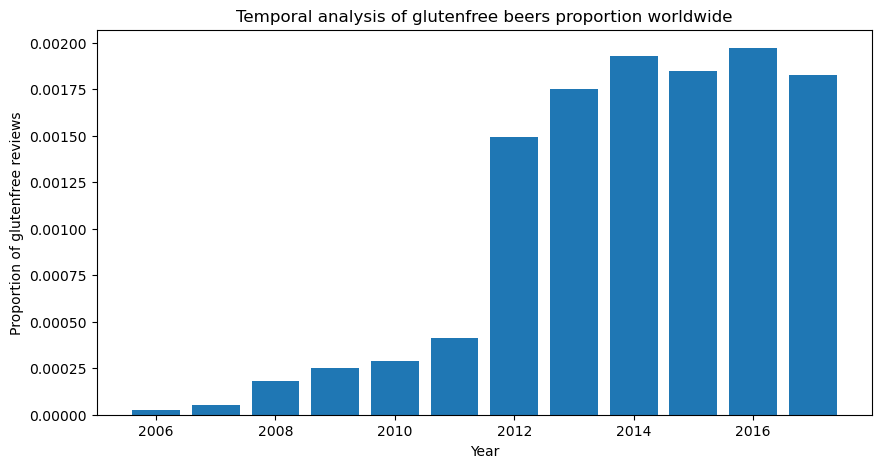

In [33]:
proportion_gf_reviews = []
for year, count in number_of_gf_reviews:
    # find the corresponding number of all reviews
    all_count = [x[1] for x in number_of_all_reviews if x[0] == year][0]
    proportion_gf_reviews.append((year, count / all_count))
    
# plot the proportion of glutenfree reviews over time
plt.figure(figsize=(10,5))
plt.bar([x[0] for x in proportion_gf_reviews], [x[1] for x in proportion_gf_reviews])
plt.xlabel('Year')
plt.ylabel('Proportion of glutenfree reviews')
plt.title('Temporal analysis of glutenfree beers proportion worldwide')

It shows that the increase of reviews for gluten-free beers is not due to the increase of total number of reviews. Thus, the increasing popularity of gluten-free beers is confirmed.

Next, the temporal evolution of numerical ratings is inspected.

In [35]:
gf_year_mean = reviews_en_fr[reviews_en_fr['glutenfree'] == True][['rating','year', 'appearance','aroma','palate','taste','overall']].groupby('year').mean()
gf_year_mean

,rating,appearance,aroma,palate,taste,overall
year,,,,,,
2006,2.333333,3.333333,3.666667,2.0,4.666667,9.666667
2007,2.250000,2.75,4.75,2.125,4.25,8.625
2008,2.403125,2.5625,4.9375,2.5625,4.65625,9.3125
2009,1.993333,2.333333,3.955556,2.288889,3.844444,7.511111
2010,2.400000,2.82,5.0,2.52,4.62,9.04
2011,2.267500,2.55,4.5625,2.45,4.3625,8.75
2012,2.794370,2.97319,5.420912,2.868633,5.477212,11.203753
2013,2.854702,3.017274,5.683301,2.848369,5.62572,11.372361
2014,2.791796,3.003096,5.520124,2.919505,5.478328,10.996904


## <span style="color: lightgreen;">correlation of the reviews with the ratings</span> TBD
